In [ ]:
import os
import sys
import pypsa

import pypsa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import logging
import warnings

# A nice package for colormaps but requires adding a dependency to the environment
#from cmcrameri import cm

from functools import reduce
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

warnings.filterwarnings("ignore")
logger = logging.getLogger(__name__)
plt.style.use("ggplot")

In [ ]:
network_path = "elec_s_100_ec_lcopt_Co2L0.0-3H_3H-gtflex_2050_0.071_DF_0export.nc"
network_path_1 = "elec_s_100_ec_lcopt_Co2L0.2-3H_3H-gtflex_2050_0.071_DF_0export.nc"
network_path_2 = "elec_s_100_ec_lcopt_Co2L0.5-3H_3H-gtflex_2050_0.071_DF_0export.nc"

### Functions definitions

In [3]:
def plot_stats25(
    df, value_col, y_lab_text="", category_col="technology", scenario_lab="", custom_cmap="Reds"
):

    tech_to_top = ["geothermal egs", "geothermal hs"]
    tech_rest = [
        x for x in df.sort_values(value_col, ascending=True)[category_col] if x not in tech_to_top
    ]

    order = tech_rest + tech_to_top
    cat_type = CategoricalDtype(categories=order, ordered=True)
    df["category"] = df[category_col].astype(cat_type)

    #return df

    df_sorted = df.sort_values("category")

    df_wide = (
        df_sorted
        #.droplevel(0)
        .pivot_table(
        #index='technology',
        columns="technology",
        #columns=["category", "color_group"],
        #values=[value_col, "category", "color_group"],
        #aggfunc={
        #    value_col: "sum",
        #    "category": lambda x: x.unique().tolist(),
        #    "color_group": lambda x: x.unique().tolist(),
        #},
        values=[value_col],
        fill_value=0,
        sort=False,
        )
    )     

    fig, ax = plt.subplots(figsize=(6, 8)) 

    #return df_wide

    df_wide.loc[[value_col]].plot(
        kind="bar",
        ax=ax,
        stacked=True,
        colormap=custom_cmap,
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    #costs_max = cost_df[value_col].sum().max() / 1e9
    #ax.set_ylim([0, costs_max])
    plt.xticks(rotation=0, fontsize=15)

    ax.set_ylabel(y_lab_text)

    ax.set_xlabel(scenario_lab)

    ax.grid(axis="x")

    ax.legend(
        handles, labels, ncol=1, loc="upper left", bbox_to_anchor=[1, 1], frameon=False
    )
    
    ax.set_facecolor('white')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.show()

    return df_wide

In [4]:
def get_plt_colors(cmap_name, c0=0, c1=1, n=128):
    standard_cmap = plt.get_cmap(cmap_name)
    colors = standard_cmap(np.linspace(c0, c1, n))
    return colors 

In [5]:
def extract_carrier_balance(
        network,
        carrier_name_list=["AC"],
        scenario_name="scenario_1",
        filter_supply=True,
    ):
    idx=pd.IndexSlice
    carrier_balance_scenario_raw =  network.statistics.energy_balance().loc[:,:,idx[carrier_name_list]].dropna()
    # A component type is not particularly relevant
    carrier_balance_scenario = carrier_balance_scenario_raw.groupby(level=1).sum().to_frame()
    carrier_balance_scenario.columns = [scenario_name]
    carrier_balance_scenario["technology"] = carrier_balance_scenario.index

    if filter_supply:
        # To keep supply only
        carrier_supply_scenario = carrier_balance_scenario[carrier_balance_scenario[scenario_name] > 0.001]
    else:
        carrier_supply_scenario = carrier_balance_scenario

    return carrier_supply_scenario

In [6]:
def extract_carrier_df(
    network_list,
    carrier_list,
    scenario_names=[
        #"s1-2035", "s2-2035", "s3-2035", "s4-2050",
        #"s5-2050", "s6-2050",
        "s7_CO2L0.0", "s7_CO2L0.8", "s7_CO2L0.5",
        #"s9"
    ],
    filter_supply=True
):

    stats_list = [None] * len(network_list)

    for i, network in enumerate(network_list):
        stats_list[i] = extract_carrier_balance(
            network,
            carrier_name_list=carrier_list,
            scenario_name=scenario_names[i],
            filter_supply=filter_supply,
        )

    merged_df = reduce(
        lambda left, right: pd.merge(
            left, right,
            on=["technology"],
            how="outer",
        ),
        stats_list
    )

    return merged_df  

In [7]:
def plot_stats25_vect(
    df, value_col_list,
    col_to_sort_on,
    y_lab_text="", category_col="technology",
    scenario_lab="", custom_cmap="Reds"
):

    #tech_to_top = ["geothermal egs", "geothermal hs"]
    tech_to_top = [
        "geoth HS", "geoth EGS",
        "geoth HS CHP200C", "geoth EGS CHP200C", "geoth EGS80C",
        #"Solar", "Onshore Wind", "Reservoir & Dam", "Run of River"
    ]
    tech_rest = [
        x for x in df.sort_values(col_to_sort_on, ascending=True)[category_col] if x not in tech_to_top
    ]

    order = tech_rest + tech_to_top
    cat_type = CategoricalDtype(categories=order, ordered=True)
    df["category"] = df[category_col].astype(cat_type)

    df_sorted = df.sort_values("category")

    #return df_sorted

    df_wide = (
        df_sorted
        .pivot_table(
        columns="technology",
        #values=[value_col, "category", "color_group"],
        #aggfunc={
        #    value_col: "sum",
        #    "category": lambda x: x.unique().tolist(),
        #    "color_group": lambda x: x.unique().tolist(),
        #},
        values=value_col_list,
        fill_value=0,
        sort=False,
        )
    )

    #return df_wide   

    fig, ax = plt.subplots(figsize=(8, 6)) 

    #return df_wide

    df_wide.loc[value_col_list].plot(
        kind="bar",
        ax=ax,
        stacked=True,
        colormap=custom_cmap,
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    #costs_max = cost_df[value_col].sum().max() / 1e9
    #ax.set_ylim([0, costs_max])
    plt.xticks(rotation=90, fontsize=15)

    ax.set_ylabel(y_lab_text)

    ax.set_xlabel(scenario_lab)

    ax.grid(axis="x")

    ax.legend(
        handles, labels, ncol=1, loc="upper left", bbox_to_anchor=[1, 1], frameon=False
    )
    
    ax.set_facecolor('white')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.show()

    return df_wide

## Load networks

In [ ]:
network_files_list = [
    network_path,
    network_path_1,
    network_path_2,
]

In [10]:
network_list = [None] * len(network_files_list)

In [11]:
for i, netw_path in enumerate(network_files_list):
   network_list[i] = pypsa.Network(netw_path) 

Index(['CO2 pipeline US0 0 <-> US0 47', 'CO2 pipeline US0 0 <-> US0 55',
       'CO2 pipeline US0 0 <-> US0 88', 'CO2 pipeline US0 0 <-> US0 89',
       'CO2 pipeline US0 0 <-> US0 96', 'CO2 pipeline US0 1 <-> US0 52',
       'CO2 pipeline US0 1 <-> US0 73', 'CO2 pipeline US0 1 <-> US0 77',
       'CO2 pipeline US0 10 <-> US0 43', 'CO2 pipeline US0 10 <-> US0 62',
       ...
       'CO2 pipeline US12 0 <-> US2 0', 'CO2 pipeline US13 0 <-> US7 0',
       'CO2 pipeline US14 0 <-> US16 0', 'CO2 pipeline US15 0 <-> US2 0',
       'CO2 pipeline US16 0 <-> US18 0', 'CO2 pipeline US19 0 <-> US21 0',
       'CO2 pipeline US19 0 <-> US9 0', 'CO2 pipeline US20 0 <-> US8 0',
       'CO2 pipeline US21 0 <-> US4 0', 'CO2 pipeline US3 0 <-> US6 0'],
      dtype='object', name='name', length=242)
Index(['CO2 pipeline US0 0 <-> US0 47', 'CO2 pipeline US0 0 <-> US0 55',
       'CO2 pipeline US0 0 <-> US0 88', 'CO2 pipeline US0 0 <-> US0 89',
       'CO2 pipeline US0 0 <-> US0 96', 'CO2 pipeline US0 1 <

#### Exploration checks

Which carriers do exist in the model?

In [12]:
network_list[0].statistics.energy_balance().index.get_level_values("bus_carrier").unique().to_list()

['AC',
 'DC',
 'oil',
 'industry heat demand(150-250C)',
 'industry heat demand(50-80C)',
 'industry heat demand(80-150C)',
 'co2',
 'residential urban decentral heat',
 'services urban decentral heat',
 'gas',
 'co2 stored',
 'urban central heat',
 'H2',
 'battery',
 'biogas',
 'biomass',
 'coal',
 'geothermal industry heat',
 'geothermal district heat',
 'geothermal heat',
 'geothermal heat egs',
 'geothermal heat hs',
 'residential rural heat',
 'residential rural water tanks',
 'residential urban decentral water tanks',
 'services rural heat',
 'services rural water tanks',
 'services urban decentral water tanks',
 'urban central water tanks']

In [13]:
network_list[0].statistics.energy_balance()[:,:,"services urban decentral heat"]

component  carrier                                        
Load       services urban decentral heat                     -1.500144e+06
Link       DAC                                               -1.965410e+03
           services urban decentral air heat pump             4.010461e+05
           services urban decentral gas boiler                4.251171e+05
           services urban decentral resistive heater          7.459326e+05
           services urban decentral water tanks charger      -3.688573e+05
           services urban decentral water tanks discharger    2.987740e+05
Generator  services urban decentral solar thermal             9.694801e+01
dtype: float64

In [14]:
network_list[0].statistics.energy_balance()[:,:,"residential urban decentral heat"]

component  carrier                                           
Load       residential urban decentral heat                     -1.150362e+09
Link       geothermal district heat                              1.175800e-01
           residential urban decentral air heat pump             2.236661e+08
           residential urban decentral gas boiler                4.350526e+08
           residential urban decentral resistive heater          5.048863e+08
           residential urban decentral water tanks charger      -6.969904e+07
           residential urban decentral water tanks discharger    5.645622e+07
Generator  residential urban decentral solar thermal             8.676083e+01
dtype: float64

### Sanity checks

In [15]:
network_list[0].statistics.energy_balance()[:,:,"biomass"]

component  carrier                           
Link       biomass                              -1.122129e+07
           biomass EOP                          -6.748633e+01
           urban central solid biomass CHP      -1.526557e+02
           urban central solid biomass CHP CC   -2.877866e+07
Generator  biomass                               1.712675e+02
Store      biomass                               4.000000e+07
dtype: float64

In [16]:
network_list[0].statistics.energy_balance()[:,:,"H2"]

component  carrier        
Link       Fischer-Tropsch   -318.93990
           H2 Electrolysis    794.72772
           H2 Fuel Cell      -372.91409
           SMR                 81.19128
           SMR CC             187.53021
           Sabatier          -372.60090
dtype: float64

In [17]:
network_list[0].statistics.energy_balance()[:,:,"co2"]

component  carrier                                             
Load       land transport oil emissions                           -1.712216e+06
Link       CCGT                                                    8.419503e+07
           DAC                                                    -1.789344e+08
           OCGT                                                    2.706571e+06
           SMR                                                     2.115246e+01
           SMR CC                                                  5.381300e+00
           biogas to gas                                          -9.714719e+04
           co2 vent                                                3.384100e-01
           coal                                                    5.264890e+06
           hot water boiler cond low temperature gas-powered       1.837618e+01
           hot water boiler cond medium temperature gas-powered    1.319296e+01
           residential rural gas boiler                 

### Extract dataframes by carriers

In [18]:
network_files_list

['elec_s_100_ec_lcopt_Co2L0.0-3H_3H-gtflex_2050_0.071_DF_0export.nc',
 'elec_s_100_ec_lcopt_Co2L0.2-3H_3H-gtflex_2050_0.071_DF_0export.nc',
 'elec_s_100_ec_lcopt_Co2L0.5-3H_3H-gtflex_2050_0.071_DF_0export.nc']

In [ ]:
ac_merged_df = extract_carrier_df(
    network_list=network_list,
    carrier_list=["AC"],
    scenario_names=[
        # TODO Adjust to fix an order of carriers
        "s7_CO2L0.0", "s7_CO2L0.8", "s7_CO2L0.5",
    ]
)

In [ ]:
industry_heat_merged_df = extract_carrier_df(
    network_list=network_list,
    carrier_list=[
        "industry heat demand(50-80C)",
        "industry heat demand(80-150C)",
        "industry heat demand(150-250C)",
    ],
    scenario_names=[
        "s7_CO2L0.0", "s7_CO2L0.8", "s7_CO2L0.5",
    ],
    filter_supply=False
)

In [21]:
network_list[0].statistics.energy_balance().index.get_level_values("bus_carrier").unique().to_list()

['AC',
 'DC',
 'oil',
 'industry heat demand(150-250C)',
 'industry heat demand(50-80C)',
 'industry heat demand(80-150C)',
 'co2',
 'residential urban decentral heat',
 'services urban decentral heat',
 'gas',
 'co2 stored',
 'urban central heat',
 'H2',
 'battery',
 'biogas',
 'biomass',
 'coal',
 'geothermal industry heat',
 'geothermal district heat',
 'geothermal heat',
 'geothermal heat egs',
 'geothermal heat hs',
 'residential rural heat',
 'residential rural water tanks',
 'residential urban decentral water tanks',
 'services rural heat',
 'services rural water tanks',
 'services urban decentral water tanks',
 'urban central water tanks']

In [ ]:
# TODO Changing/discharging must be addressed in a more appropriate way for space heating
# to get a more clear picture
space_heat_merged_df = extract_carrier_df(
    network_list=network_list,
    carrier_list=[
        "geothermal district heat",
        "residential rural heat",
        "residential urban decentral heat",
        "services rural heat",
        "services urban decentral heat",
        "residential rural water tanks",
        "residential urban decentral water tanks",
        "services rural water tanks",
        "services urban decentral water tanks",
        "urban central water tanks"       
    ],
    scenario_names=[
        #"s1-2035", "s2-2035", "s3-2035", "s4-2050",
        #"s5-2050", "s6-2050",
        "s7_CO2L0.0", "s7_CO2L0.8", "s7_CO2L0.5",
        #"s9"
    ],
    filter_supply=False
)

#### Clean-up carrier datasets

In [23]:
# Hard-coded according to the current implementation
geothermal_nice_names = {
    "geothermal egs": "geoth EGS",
    "geothermal hs": "geoth HS",
    'steam200degC_power_residheat80degC_egs': "geoth EGS CHP200C",
    'steam200degC_power_residheat80degC_hs': "geoth HS CHP200C",
    "pwr_residheat80degC_egs": "geoth EGS80C",
    "Geothermal": "geoth HS existing"
}


#### AC balance

In [24]:
ac_merged_df2 = ac_merged_df.copy()
ac_merged_df2["technology"].replace(geothermal_nice_names, inplace=True)

In [25]:
# Small values are creating visual noise
ac_filtered_df2 = ac_merged_df2.copy()
# Filter according to the focus of the screening plot
threshold = 0.05 * ac_filtered_df2["s7_CO2L0.0"].mean()

ac_filtered_clean_df = ac_filtered_df2[
    (
        (ac_filtered_df2["s7_CO2L0.0"] > threshold) |
        (ac_filtered_df2["technology"].str.contains("geoth", case=False))
    ) #& 
    ## A hotfix to explude CHPs from the energy mix
    ## must be incorporated into the modeling run itself
    #(~ac_filtered_df["technology"].str.contains("urban centr", case=False))
]

#### Industry heat balance

In [26]:
industry_heat_merged_df2 = industry_heat_merged_df.copy()
industry_heat_merged_df2["technology"].replace(geothermal_nice_names, inplace=True)

industry_filtered_clean_df = industry_heat_merged_df2

#### Space heating balance

In [27]:
space_heat_merged_df2 = space_heat_merged_df.copy()
space_heat_merged_df2["technology"].replace(geothermal_nice_names, inplace=True)

space_heat_filtered_clean_df = space_heat_merged_df2

#### Create tailored color pallets 

In [28]:
combined_simple_colors = np.vstack(
    [
        #get_plt_colors("OrRd", c0=0.3, c1=0.9, n=3),
        get_plt_colors("Blues", c0=0.1, c1=0.9, n=7),
        get_plt_colors("Reds", c0=0.3, c1=0.8, n=5),    
        #get_plt_colors("Greens", c0=0.3, c1=0.9, n=4),
        #get_plt_colors("Grays", c0=0.3, c1=0.9, n=4),
        #get_plt_colors("Reds", c0=0.3, c1=0.9, n=3),
    ]
)

cmap_simple_custom = ListedColormap(combined_simple_colors, name="RedsOranges")

The version bellow gives more visually appealing outputs but require an additional dependency `cmcrameri` (better to do in a new environment), and uncommenting an import from `cmcrameri` namespace in the first code block.

In [ ]:
#combined_fancy_colors = np.vstack(
#    [
#        #get_plt_colors("OrRd", c0=0.3, c1=0.9, n=3),
#        #get_plt_colors("Blues", c0=0.1, c1=0.9, n=25),
#
#        # looks nice
#        #cm.imolaS(np.linspace(0.05, 0.9, 8)),
#        # appropriate for a focused representation
#        #cm.romaO_r(np.linspace(0.3, 0.9, 10)),
#        # good for the full spectrum
#        #cm.roma(np.linspace(0.05, 0.9, 20)),
#        # looks good
#        cm.tokyo(np.linspace(0.0, 0.95, 7)),
#        #cm.imolaS(np.linspace(0.0, 1, 10)),
#        # looks ok
#        #cm.davosS(np.linspace(0.0, 1, 10)),
#        
#        # Another good option
#        
#        #cm.vanimo(np.linspace(0.0, 1, 7)),
#        
#        get_plt_colors("Reds", c0=0.3, c1=0.8, n=5),    
#        #get_plt_colors("Greens", c0=0.3, c1=0.9, n=4),
#        #get_plt_colors("Grays", c0=0.3, c1=0.9, n=4),
#        #get_plt_colors("Reds", c0=0.3, c1=0.9, n=3),
#    ]
#)
#
#cmap_fancy_custom = ListedColormap(combined_fancy_colors, name="GeoFocus")

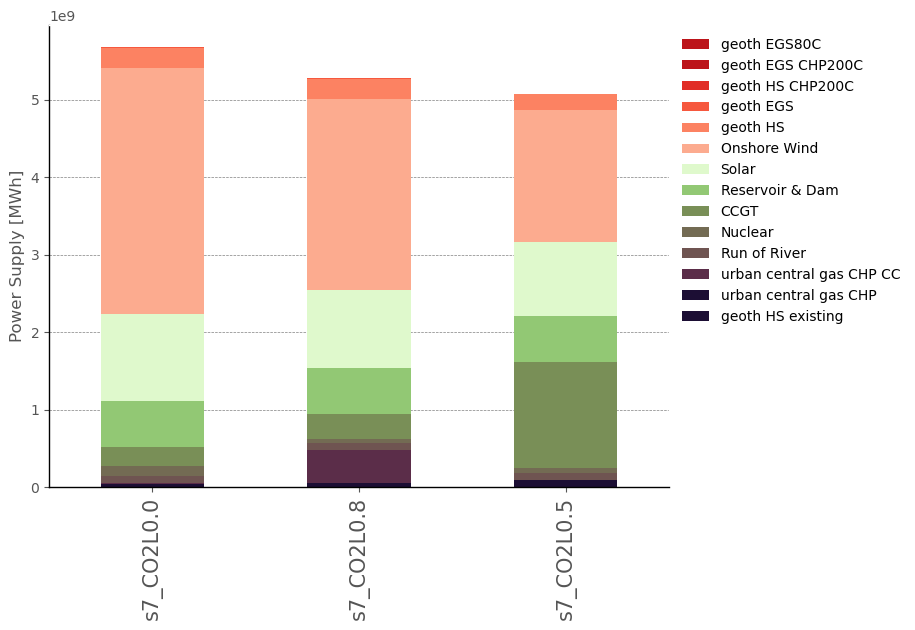

In [ ]:
res = plot_stats25_vect(
    ac_filtered_clean_df,
    value_col_list=[
       's7_CO2L0.0', 's7_CO2L0.8', 's7_CO2L0.5'
    ],
    col_to_sort_on="s7_CO2L0.0",                
    y_lab_text="Power Supply [MWh]",
    category_col="technology",
    scenario_lab="",

    # Good for the overall balance
    #custom_cmap=cm.romaO

    #custom_cmap=cmap_fancy_custom

    custom_cmap=cmap_simple_custom
    
    # Default
    #custom_cmap="Reds"
)

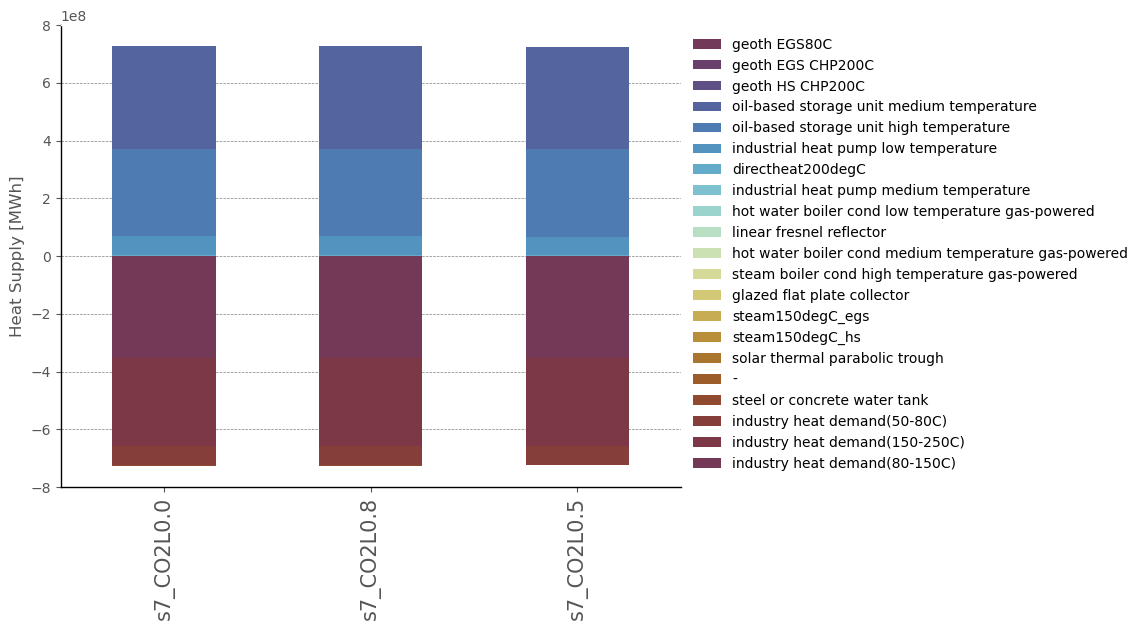

In [ ]:
res = plot_stats25_vect(
    industry_filtered_clean_df,
    value_col_list=[
       's7_CO2L0.0', 's7_CO2L0.8', 's7_CO2L0.5'
    ],
    col_to_sort_on="s7_CO2L0.0",                
    y_lab_text="Heat Supply [MWh]",
    category_col="technology",
    scenario_lab="",

    # Good for the overall balance
    #custom_cmap=cm.romaO

    #custom_cmap=cmap_fancy_custom

    custom_cmap=cmap_simple_custom
    
    # Default
    #custom_cmap="Reds"
)

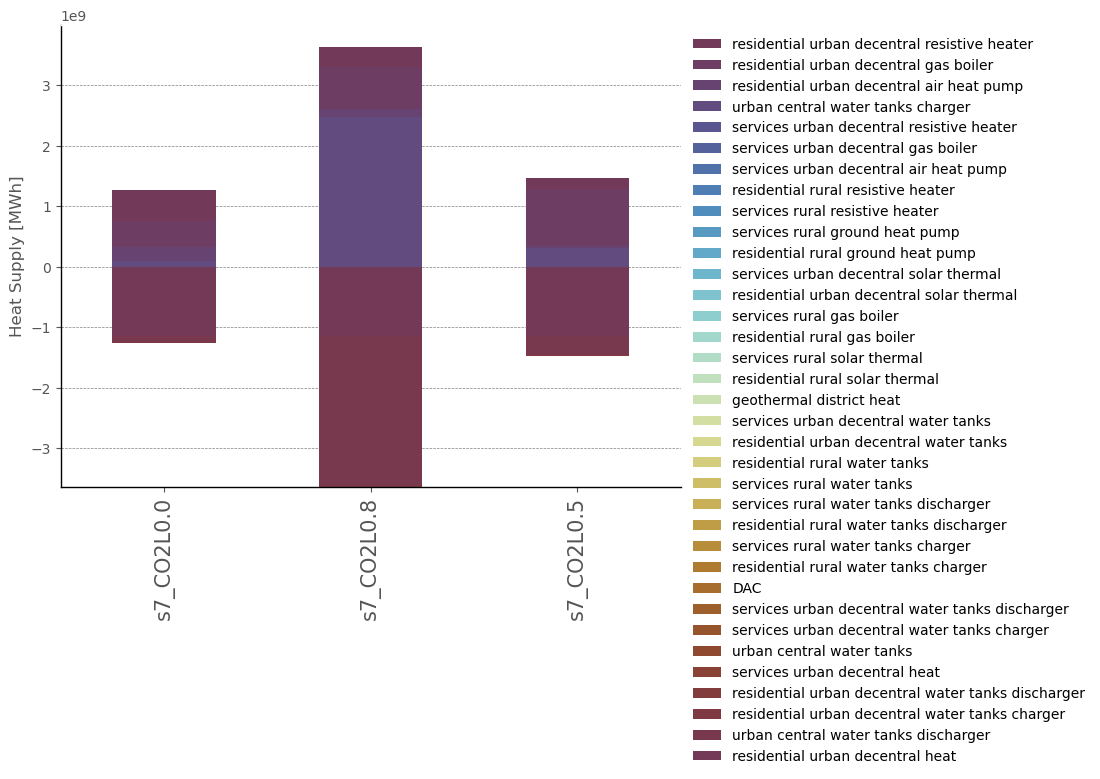

In [ ]:
res = plot_stats25_vect(
    space_heat_filtered_clean_df,
    value_col_list=[
       's7_CO2L0.0', 's7_CO2L0.8', 's7_CO2L0.5'
    ],
    col_to_sort_on="s7_CO2L0.0",
    y_lab_text="Heat Supply [MWh]",
    category_col="technology",
    scenario_lab="",

    # Good for the overall balance
    #custom_cmap=cm.romaO

    #custom_cmap=cmap_fancy_custom

    custom_cmap=cmap_simple_custom
    
    # Default
    #custom_cmap="Reds"
)